# Program description of machine learning modeling (CNN-regression)

## Overview:
This module is responsible for building a Convolutional Neural Network (CNN) model for regression tasks. It reads the normalized dataset output by **Module 9**, trains the CNN model, and saves the best-performing model. This module is designed to work in parallel with other network models, such as MLP, for comparison purposes.

## Key Steps:
1. **Dataset Input**:
   - The normalized training and validation datasets (features and labels) generated by **Module 9** are used as input for the CNN model.
   
2. **CNN Model Construction**:
   - A Convolutional Neural Network (CNN) is built to perform regression, meaning the model will output continuous values based on the input features.

3. **Training and Model Selection**:
   - The model is trained using the training dataset, and the best model is saved after training based on performance metrics such as accuracy or loss.
   
4. **Prediction**:
   - After training, the CNN model is used to predict values on the test set, and its performance is evaluated.
   
5. **Output**:
   - The trained model is saved under the `datasets-ml` folder in the current directory.
   - Each run saves the model file with a timestamp, e.g., `MLPmodel--{current_time}`.

## Input:
- The dataset is read from the output of **Module 9** (normalized data set).
- The files containing the training and validation data include both feature and label files.

## Output:
- The best-trained CNN model is saved in the `datasets-ml` folder.
- The model filename contains a timestamp indicating the time of training.


contacts：zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import logging
from tensorflow.keras import layers, models, regularizers
#from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import sys
import keras.callbacks

2024-10-31 15:42:40.974527: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['tensorflow', 'numpy', 'joblib', 'matplotlib','sklearn']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

tensorflow: 2.9.1
numpy: 1.23.5
joblib: 1.4.0
matplotlib: 3.7.5
sklearn: 1.3.2
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter settings (input file, output file)

## Input File Path:
- `dir_data`: Specifies the directory where the normalized dataset is located.
- The dataset includes **training**, **validation**, and **test** datasets (features and labels) generated in **Module 9**.
- Example: `'0926-datasets-2/datasets(JmolNN)-pre-xmu-cn'` (path where normalized data is stored).

## Output File Path:
- `output_path`: Specifies the directory where the CNN model will be saved after training.
- The trained model will be stored under the `datasets-ml` folder in the current working path.
- Example: `'0926-datasets-ml/ml-cn-xmu-(JmolNN)'` (path where the model will be saved).

## Model Output Filename:
- `current_time`: Timestamp is used to create a unique filename for each model.
- The model filename will follow the pattern: `CNNmodel-{current_time}`.
- Example: `'CNNmodel-20230101_1200'` (timestamp format `YYYYMMDD_HHMM`).

## Log File:
- `log_file_path`: Path where the training log file will be stored, including details of training, dataset sizes, and any relevant logs.
- Example: `'training_log.txt'`.

## Data Files:
- Training, validation, and test feature and label files are loaded from the datastest_JmolNN.txt`: Test labels


In [3]:
# Set input file path
dir_data = '0926-datasets-2/datasets(JmolNN)-pre-xmu-cn'
# Set output file save path
output_path = '0926-datasets-ml/ml-cn-xmu-(JmolNN)'
# Output save file name and add timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M")
dir_output=os.path.join(output_path,f'CNNmodel-{current_time}')
# Check if the input path exists
if os.path.exists(dir_data):
    print(f"File '{dir_data}' exists.")
else:
    raise FileNotFoundError(f"File '{dir_data}' does not exist.")
# Load training, validation, and test datasets
os.makedirs(dir_output, exist_ok=True)
file_train_feature = os.path.join(dir_data, 'xmu_train_JmolNN.txt')
file_train_label = os.path.join(dir_data, 'label_cn_train_JmolNN.txt')
file_valid_feature = os.path.join(dir_data, 'xmu_valid_JmolNN.txt')
file_valid_label = os.path.join(dir_data, 'label_cn_valid_JmolNN.txt')
file_test_feature = os.path.join(dir_data, 'xmu_test_JmolNN.txt')
file_test_label = os.path.join(dir_data, 'label_cn_test_JmolNN.txt')
# Set log file
log_file_path = os.path.join(dir_output, 'training_log.txt')
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_file_path), logging.StreamHandler()])
# Read data
X_train = np.loadtxt(file_train_feature)
y_train = np.loadtxt(file_train_label, dtype=float)
X_valid = np.loadtxt(file_valid_feature)
y_valid = np.loadtxt(file_valid_label, dtype=float)
X_test = np.loadtxt(file_test_feature)
y_test = np.loadtxt(file_test_label, dtype=float)
# Prepare messages for dataset sizes
train_size_message = f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}"
valid_size_message = f"Validation set size: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}"
test_size_message = f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}"
print(train_size_message)
print(valid_size_message)
print(test_size_message)
# Log dataset sizes
logging.info(train_size_message)
logging.info(valid_size_message)
logging.info(test_size_message)

File '0926-datasets-2/datasets(JmolNN)-pre-xmu-cn' exists.


Training set size: X_train: (3500, 1000), y_train: (3500,)
Validation set size: X_valid: (1000, 1000), y_valid: (1000,)
Test set size: X_test: (501, 1000), y_test: (501,)


Training set size: X_train: (3500, 1000), y_train: (3500,)
Validation set size: X_valid: (1000, 1000), y_valid: (1000,)
Test set size: X_test: (501, 1000), y_test: (501,)


# Build a CNN regression model and save the best model results

In [4]:
# Reshape the input data to (number of samples, number of features, 1, 1) to adapt to the CNN input format
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_valid = X_valid.reshape(-1, X_valid.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)
# Build 1D CNN model
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(1)
])

# Compile the model
#model.compile(optimizer='adam', 
              #loss='mse', 
             # metrics=['mae'])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
             loss='mse',  
              metrics=['mae', 'mse'])
# Print model structure
model.summary()
# Redirect the output of model.summary() to a file
model_summary_path = os.path.join(dir_output, 'model_summary.txt')

# Use context manager to open a file and write the model summary
with open(model_summary_path, 'w') as f:
    # Redirect standard output to the file
    model.summary(print_fn=lambda x: f.write(x + '\n'))

print(f"Model summary saved to: {model_summary_path}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 128)          24704     
                                                                 
 flatten (Flatten)           (None, 31488)             0

2024-10-31 15:42:45.169950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=20,         # Stop if no improvement for 20 epochs
                               restore_best_weights=True,  # Restore the best weights
                               min_delta=0.001,     # Minimum change to qualify as improvement
                               mode='min')          # Minimize validation loss

# Optionally, define ModelCheckpoint to save the best model during training
model_checkpoint = ModelCheckpoint(os.path.join(dir_output, 'best_model.h5'), 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   mode='min')

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_message = (f"Epoch {epoch + 1}, "
                       f"Loss: {logs['loss']:.4f}, "
                       f"Val_Loss: {logs['val_loss']:.4f}, ")
        logging.info(log_message)

# Train the model with EarlyStopping and ModelCheckpoint
history = model.fit(X_train, y_train, 
                    epochs=150, 
                    batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping, model_checkpoint, CustomCallback()],
                    verbose=1)

# Save the best model (if not already handled by ModelCheckpoint)
#model_path = os.path.join(dir_output, 'best_model.h5')
#model.save(model_path)
#print(f"Best model saved to: {model_path}")

# Evaluate model performance
loss, mae, mse = model.evaluate(X_test, y_test)
print(f'Test Mean Absolute Error: {mae}')
print(f'Test Mean Squared Error: {mse}')


Epoch 1/150
109/110 [============================>.] - ETA: 0s - loss: 3.5304 - mae: 1.1841 - mse: 3.5304

Epoch 1, Loss: 3.5207, Val_Loss: 0.8811, 


110/110 [==============================] - 3s 25ms/step - loss: 3.5207 - mae: 1.1823 - mse: 3.5207 - val_loss: 0.8811 - val_mae: 0.7397 - val_mse: 0.8811
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 0.9057 - mae: 0.7277 - mse: 0.9057

Epoch 2, Loss: 0.9057, Val_Loss: 1.0623, 


110/110 [==============================] - 2s 21ms/step - loss: 0.9057 - mae: 0.7277 - mse: 0.9057 - val_loss: 1.0623 - val_mae: 0.8090 - val_mse: 1.0623
Epoch 3/150
109/110 [============================>.] - ETA: 0s - loss: 0.8319 - mae: 0.7065 - mse: 0.8319

Epoch 3, Loss: 0.8314, Val_Loss: 0.6875, 


110/110 [==============================] - 3s 25ms/step - loss: 0.8314 - mae: 0.7063 - mse: 0.8314 - val_loss: 0.6875 - val_mae: 0.6416 - val_mse: 0.6875
Epoch 4/150
109/110 [============================>.] - ETA: 0s - loss: 0.7232 - mae: 0.6598 - mse: 0.7232

Epoch 4, Loss: 0.7249, Val_Loss: 0.7461, 


110/110 [==============================] - 2s 21ms/step - loss: 0.7249 - mae: 0.6608 - mse: 0.7249 - val_loss: 0.7461 - val_mae: 0.6924 - val_mse: 0.7461
Epoch 5/150
109/110 [============================>.] - ETA: 0s - loss: 0.7047 - mae: 0.6414 - mse: 0.7047

Epoch 5, Loss: 0.7041, Val_Loss: 0.7455, 


110/110 [==============================] - 2s 21ms/step - loss: 0.7041 - mae: 0.6414 - mse: 0.7041 - val_loss: 0.7455 - val_mae: 0.7030 - val_mse: 0.7455
Epoch 6/150
109/110 [============================>.] - ETA: 0s - loss: 0.7411 - mae: 0.6581 - mse: 0.7411

Epoch 6, Loss: 0.7429, Val_Loss: 0.9727, 


110/110 [==============================] - 2s 21ms/step - loss: 0.7429 - mae: 0.6585 - mse: 0.7429 - val_loss: 0.9727 - val_mae: 0.7149 - val_mse: 0.9727
Epoch 7/150
109/110 [============================>.] - ETA: 0s - loss: 0.6132 - mae: 0.5938 - mse: 0.6132

Epoch 7, Loss: 0.6126, Val_Loss: 0.5254, 


110/110 [==============================] - 3s 25ms/step - loss: 0.6126 - mae: 0.5937 - mse: 0.6126 - val_loss: 0.5254 - val_mae: 0.5534 - val_mse: 0.5254
Epoch 8/150
109/110 [============================>.] - ETA: 0s - loss: 0.5853 - mae: 0.5827 - mse: 0.5853

Epoch 8, Loss: 0.5857, Val_Loss: 0.5119, 


110/110 [==============================] - 3s 25ms/step - loss: 0.5857 - mae: 0.5832 - mse: 0.5857 - val_loss: 0.5119 - val_mae: 0.5548 - val_mse: 0.5119
Epoch 9/150
109/110 [============================>.] - ETA: 0s - loss: 0.5861 - mae: 0.5737 - mse: 0.5861

Epoch 9, Loss: 0.5849, Val_Loss: 0.4780, 


110/110 [==============================] - 3s 24ms/step - loss: 0.5849 - mae: 0.5730 - mse: 0.5849 - val_loss: 0.4780 - val_mae: 0.5211 - val_mse: 0.4780
Epoch 10/150
108/110 [============================>.] - ETA: 0s - loss: 0.5337 - mae: 0.5519 - mse: 0.5337

Epoch 10, Loss: 0.5338, Val_Loss: 0.5465, 


110/110 [==============================] - 2s 21ms/step - loss: 0.5338 - mae: 0.5526 - mse: 0.5338 - val_loss: 0.5465 - val_mae: 0.5561 - val_mse: 0.5465
Epoch 11/150
108/110 [============================>.] - ETA: 0s - loss: 0.5212 - mae: 0.5450 - mse: 0.5212

Epoch 11, Loss: 0.5208, Val_Loss: 0.4871, 


110/110 [==============================] - 2s 20ms/step - loss: 0.5208 - mae: 0.5453 - mse: 0.5208 - val_loss: 0.4871 - val_mae: 0.5428 - val_mse: 0.4871
Epoch 12/150
107/110 [============================>.] - ETA: 0s - loss: 0.4764 - mae: 0.5240 - mse: 0.4764

Epoch 12, Loss: 0.4845, Val_Loss: 0.5297, 


110/110 [==============================] - 2s 20ms/step - loss: 0.4845 - mae: 0.5274 - mse: 0.4845 - val_loss: 0.5297 - val_mae: 0.5655 - val_mse: 0.5297
Epoch 13/150
107/110 [============================>.] - ETA: 0s - loss: 0.5557 - mae: 0.5583 - mse: 0.5557

Epoch 13, Loss: 0.5530, Val_Loss: 0.6930, 


110/110 [==============================] - 2s 20ms/step - loss: 0.5530 - mae: 0.5567 - mse: 0.5530 - val_loss: 0.6930 - val_mae: 0.6135 - val_mse: 0.6930
Epoch 14/150
109/110 [============================>.] - ETA: 0s - loss: 0.5028 - mae: 0.5303 - mse: 0.5028

Epoch 14, Loss: 0.5018, Val_Loss: 0.4569, 


110/110 [==============================] - 3s 24ms/step - loss: 0.5018 - mae: 0.5298 - mse: 0.5018 - val_loss: 0.4569 - val_mae: 0.4997 - val_mse: 0.4569
Epoch 15/150
107/110 [============================>.] - ETA: 0s - loss: 0.4332 - mae: 0.4933 - mse: 0.4332

Epoch 15, Loss: 0.4335, Val_Loss: 0.4320, 


110/110 [==============================] - 3s 24ms/step - loss: 0.4335 - mae: 0.4925 - mse: 0.4335 - val_loss: 0.4320 - val_mae: 0.4909 - val_mse: 0.4320
Epoch 16/150
108/110 [============================>.] - ETA: 0s - loss: 0.4396 - mae: 0.4979 - mse: 0.4396

Epoch 16, Loss: 0.4373, Val_Loss: 0.4515, 


110/110 [==============================] - 2s 20ms/step - loss: 0.4373 - mae: 0.4967 - mse: 0.4373 - val_loss: 0.4515 - val_mae: 0.4974 - val_mse: 0.4515
Epoch 17/150
109/110 [============================>.] - ETA: 0s - loss: 0.4278 - mae: 0.4929 - mse: 0.4278

Epoch 17, Loss: 0.4272, Val_Loss: 0.4433, 


110/110 [==============================] - 2s 20ms/step - loss: 0.4272 - mae: 0.4926 - mse: 0.4272 - val_loss: 0.4433 - val_mae: 0.5091 - val_mse: 0.4433
Epoch 18/150
109/110 [============================>.] - ETA: 0s - loss: 0.4277 - mae: 0.4914 - mse: 0.4277

Epoch 18, Loss: 0.4282, Val_Loss: 0.4515, 


110/110 [==============================] - 2s 20ms/step - loss: 0.4282 - mae: 0.4915 - mse: 0.4282 - val_loss: 0.4515 - val_mae: 0.5121 - val_mse: 0.4515
Epoch 19/150
110/110 [==============================] - ETA: 0s - loss: 0.4146 - mae: 0.4844 - mse: 0.4146

Epoch 19, Loss: 0.4146, Val_Loss: 0.4335, 


110/110 [==============================] - 2s 19ms/step - loss: 0.4146 - mae: 0.4844 - mse: 0.4146 - val_loss: 0.4335 - val_mae: 0.4868 - val_mse: 0.4335
Epoch 20/150
109/110 [============================>.] - ETA: 0s - loss: 0.4803 - mae: 0.5130 - mse: 0.4803

Epoch 20, Loss: 0.4793, Val_Loss: 0.4584, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4793 - mae: 0.5124 - mse: 0.4793 - val_loss: 0.4584 - val_mae: 0.5161 - val_mse: 0.4584
Epoch 21/150
109/110 [============================>.] - ETA: 0s - loss: 0.4070 - mae: 0.4778 - mse: 0.4070

Epoch 21, Loss: 0.4079, Val_Loss: 0.3923, 


110/110 [==============================] - 2s 22ms/step - loss: 0.4079 - mae: 0.4780 - mse: 0.4079 - val_loss: 0.3923 - val_mae: 0.4688 - val_mse: 0.3923
Epoch 22/150
109/110 [============================>.] - ETA: 0s - loss: 0.4065 - mae: 0.4779 - mse: 0.4065

Epoch 22, Loss: 0.4067, Val_Loss: 0.4385, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4067 - mae: 0.4782 - mse: 0.4067 - val_loss: 0.4385 - val_mae: 0.4820 - val_mse: 0.4385
Epoch 23/150
109/110 [============================>.] - ETA: 0s - loss: 0.4124 - mae: 0.4774 - mse: 0.4124

Epoch 23, Loss: 0.4125, Val_Loss: 0.5708, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4125 - mae: 0.4775 - mse: 0.4125 - val_loss: 0.5708 - val_mae: 0.5423 - val_mse: 0.5708
Epoch 24/150
109/110 [============================>.] - ETA: 0s - loss: 0.4211 - mae: 0.4853 - mse: 0.4211

Epoch 24, Loss: 0.4208, Val_Loss: 0.4355, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4208 - mae: 0.4853 - mse: 0.4208 - val_loss: 0.4355 - val_mae: 0.4896 - val_mse: 0.4355
Epoch 25/150
109/110 [============================>.] - ETA: 0s - loss: 0.4177 - mae: 0.4867 - mse: 0.4177

Epoch 25, Loss: 0.4172, Val_Loss: 0.5336, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4172 - mae: 0.4867 - mse: 0.4172 - val_loss: 0.5336 - val_mae: 0.5292 - val_mse: 0.5336
Epoch 26/150
109/110 [============================>.] - ETA: 0s - loss: 0.3806 - mae: 0.4640 - mse: 0.3806

Epoch 26, Loss: 0.3803, Val_Loss: 0.5005, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3803 - mae: 0.4638 - mse: 0.3803 - val_loss: 0.5005 - val_mae: 0.5117 - val_mse: 0.5005
Epoch 27/150
109/110 [============================>.] - ETA: 0s - loss: 0.4049 - mae: 0.4766 - mse: 0.4049

Epoch 27, Loss: 0.4046, Val_Loss: 0.4747, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4046 - mae: 0.4766 - mse: 0.4046 - val_loss: 0.4747 - val_mae: 0.4967 - val_mse: 0.4747
Epoch 28/150
109/110 [============================>.] - ETA: 0s - loss: 0.4135 - mae: 0.4789 - mse: 0.4135

Epoch 28, Loss: 0.4130, Val_Loss: 0.4575, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4130 - mae: 0.4785 - mse: 0.4130 - val_loss: 0.4575 - val_mae: 0.4993 - val_mse: 0.4575
Epoch 29/150
109/110 [============================>.] - ETA: 0s - loss: 0.4307 - mae: 0.4863 - mse: 0.4307

Epoch 29, Loss: 0.4301, Val_Loss: 0.6432, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4301 - mae: 0.4861 - mse: 0.4301 - val_loss: 0.6432 - val_mae: 0.6061 - val_mse: 0.6432
Epoch 30/150
108/110 [============================>.] - ETA: 0s - loss: 0.4075 - mae: 0.4757 - mse: 0.4075

Epoch 30, Loss: 0.4051, Val_Loss: 0.5242, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4051 - mae: 0.4741 - mse: 0.4051 - val_loss: 0.5242 - val_mae: 0.5150 - val_mse: 0.5242
Epoch 31/150
109/110 [============================>.] - ETA: 0s - loss: 0.3842 - mae: 0.4627 - mse: 0.3842

Epoch 31, Loss: 0.3836, Val_Loss: 0.3807, 


110/110 [==============================] - 2s 22ms/step - loss: 0.3836 - mae: 0.4622 - mse: 0.3836 - val_loss: 0.3807 - val_mae: 0.4428 - val_mse: 0.3807
Epoch 32/150
109/110 [============================>.] - ETA: 0s - loss: 0.4262 - mae: 0.4874 - mse: 0.4262

Epoch 32, Loss: 0.4268, Val_Loss: 0.4137, 


110/110 [==============================] - 2s 18ms/step - loss: 0.4268 - mae: 0.4877 - mse: 0.4268 - val_loss: 0.4137 - val_mae: 0.4741 - val_mse: 0.4137
Epoch 33/150
109/110 [============================>.] - ETA: 0s - loss: 0.3462 - mae: 0.4441 - mse: 0.3462

Epoch 33, Loss: 0.3455, Val_Loss: 0.4276, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3455 - mae: 0.4435 - mse: 0.3455 - val_loss: 0.4276 - val_mae: 0.4846 - val_mse: 0.4276
Epoch 34/150
109/110 [============================>.] - ETA: 0s - loss: 0.3462 - mae: 0.4413 - mse: 0.3462

Epoch 34, Loss: 0.3465, Val_Loss: 0.7602, 


110/110 [==============================] - 2s 19ms/step - loss: 0.3465 - mae: 0.4413 - mse: 0.3465 - val_loss: 0.7602 - val_mae: 0.5807 - val_mse: 0.7602
Epoch 35/150
108/110 [============================>.] - ETA: 0s - loss: 0.3755 - mae: 0.4570 - mse: 0.3755

Epoch 35, Loss: 0.3753, Val_Loss: 0.5113, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3753 - mae: 0.4574 - mse: 0.3753 - val_loss: 0.5113 - val_mae: 0.5013 - val_mse: 0.5113
Epoch 36/150
109/110 [============================>.] - ETA: 0s - loss: 0.3673 - mae: 0.4533 - mse: 0.3673

Epoch 36, Loss: 0.3686, Val_Loss: 0.5208, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3686 - mae: 0.4541 - mse: 0.3686 - val_loss: 0.5208 - val_mae: 0.5731 - val_mse: 0.5208
Epoch 37/150
109/110 [============================>.] - ETA: 0s - loss: 0.3654 - mae: 0.4545 - mse: 0.3654

Epoch 37, Loss: 0.3650, Val_Loss: 0.4819, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3650 - mae: 0.4543 - mse: 0.3650 - val_loss: 0.4819 - val_mae: 0.4821 - val_mse: 0.4819
Epoch 38/150
108/110 [============================>.] - ETA: 0s - loss: 0.3940 - mae: 0.4754 - mse: 0.3940

Epoch 38, Loss: 0.3960, Val_Loss: 0.4055, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3960 - mae: 0.4761 - mse: 0.3960 - val_loss: 0.4055 - val_mae: 0.4723 - val_mse: 0.4055
Epoch 39/150
109/110 [============================>.] - ETA: 0s - loss: 0.3907 - mae: 0.4753 - mse: 0.3907

Epoch 39, Loss: 0.3902, Val_Loss: 0.3864, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3902 - mae: 0.4751 - mse: 0.3902 - val_loss: 0.3864 - val_mae: 0.4699 - val_mse: 0.3864
Epoch 40/150
109/110 [============================>.] - ETA: 0s - loss: 0.3460 - mae: 0.4374 - mse: 0.3460

Epoch 40, Loss: 0.3460, Val_Loss: 0.3686, 


110/110 [==============================] - 2s 22ms/step - loss: 0.3460 - mae: 0.4375 - mse: 0.3460 - val_loss: 0.3686 - val_mae: 0.4469 - val_mse: 0.3686
Epoch 41/150
109/110 [============================>.] - ETA: 0s - loss: 0.3076 - mae: 0.4167 - mse: 0.3076

Epoch 41, Loss: 0.3082, Val_Loss: 0.4966, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3082 - mae: 0.4170 - mse: 0.3082 - val_loss: 0.4966 - val_mae: 0.4977 - val_mse: 0.4966
Epoch 42/150
109/110 [============================>.] - ETA: 0s - loss: 0.3854 - mae: 0.4585 - mse: 0.3854

Epoch 42, Loss: 0.3850, Val_Loss: 0.4739, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3850 - mae: 0.4585 - mse: 0.3850 - val_loss: 0.4739 - val_mae: 0.4932 - val_mse: 0.4739
Epoch 43/150
109/110 [============================>.] - ETA: 0s - loss: 0.3357 - mae: 0.4278 - mse: 0.3357

Epoch 43, Loss: 0.3365, Val_Loss: 0.3930, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3365 - mae: 0.4281 - mse: 0.3365 - val_loss: 0.3930 - val_mae: 0.4529 - val_mse: 0.3930
Epoch 44/150
109/110 [============================>.] - ETA: 0s - loss: 0.3176 - mae: 0.4232 - mse: 0.3176

Epoch 44, Loss: 0.3169, Val_Loss: 0.3846, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3169 - mae: 0.4227 - mse: 0.3169 - val_loss: 0.3846 - val_mae: 0.4453 - val_mse: 0.3846
Epoch 45/150
109/110 [============================>.] - ETA: 0s - loss: 0.3037 - mae: 0.4116 - mse: 0.3037

Epoch 45, Loss: 0.3038, Val_Loss: 0.3855, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3038 - mae: 0.4115 - mse: 0.3038 - val_loss: 0.3855 - val_mae: 0.4484 - val_mse: 0.3855
Epoch 46/150
109/110 [============================>.] - ETA: 0s - loss: 0.2992 - mae: 0.4049 - mse: 0.2992

Epoch 46, Loss: 0.2991, Val_Loss: 0.3960, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2991 - mae: 0.4050 - mse: 0.2991 - val_loss: 0.3960 - val_mae: 0.4684 - val_mse: 0.3960
Epoch 47/150
109/110 [============================>.] - ETA: 0s - loss: 0.3161 - mae: 0.4232 - mse: 0.3161

Epoch 47, Loss: 0.3166, Val_Loss: 0.4364, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3166 - mae: 0.4234 - mse: 0.3166 - val_loss: 0.4364 - val_mae: 0.4731 - val_mse: 0.4364
Epoch 48/150
109/110 [============================>.] - ETA: 0s - loss: 0.3240 - mae: 0.4276 - mse: 0.3240

Epoch 48, Loss: 0.3239, Val_Loss: 0.4323, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3239 - mae: 0.4276 - mse: 0.3239 - val_loss: 0.4323 - val_mae: 0.4834 - val_mse: 0.4323
Epoch 49/150
109/110 [============================>.] - ETA: 0s - loss: 0.3409 - mae: 0.4370 - mse: 0.3409

Epoch 49, Loss: 0.3405, Val_Loss: 0.5995, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3405 - mae: 0.4367 - mse: 0.3405 - val_loss: 0.5995 - val_mae: 0.5449 - val_mse: 0.5995
Epoch 50/150
109/110 [============================>.] - ETA: 0s - loss: 0.3129 - mae: 0.4155 - mse: 0.3129

Epoch 50, Loss: 0.3135, Val_Loss: 0.3866, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3135 - mae: 0.4158 - mse: 0.3135 - val_loss: 0.3866 - val_mae: 0.4484 - val_mse: 0.3866
Epoch 51/150
109/110 [============================>.] - ETA: 0s - loss: 0.3062 - mae: 0.4135 - mse: 0.3062

Epoch 51, Loss: 0.3056, Val_Loss: 0.4037, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3056 - mae: 0.4129 - mse: 0.3056 - val_loss: 0.4037 - val_mae: 0.4597 - val_mse: 0.4037
Epoch 52/150
108/110 [============================>.] - ETA: 0s - loss: 0.3327 - mae: 0.4277 - mse: 0.3327

Epoch 52, Loss: 0.3344, Val_Loss: 0.3933, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3344 - mae: 0.4293 - mse: 0.3344 - val_loss: 0.3933 - val_mae: 0.4506 - val_mse: 0.3933
Epoch 53/150
110/110 [==============================] - ETA: 0s - loss: 0.3073 - mae: 0.4138 - mse: 0.3073

Epoch 53, Loss: 0.3073, Val_Loss: 0.4380, 


110/110 [==============================] - 2s 18ms/step - loss: 0.3073 - mae: 0.4138 - mse: 0.3073 - val_loss: 0.4380 - val_mae: 0.4803 - val_mse: 0.4380
Epoch 54/150
109/110 [============================>.] - ETA: 0s - loss: 0.2890 - mae: 0.4030 - mse: 0.2890

Epoch 54, Loss: 0.2890, Val_Loss: 0.4251, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2890 - mae: 0.4030 - mse: 0.2890 - val_loss: 0.4251 - val_mae: 0.4886 - val_mse: 0.4251
Epoch 55/150
109/110 [============================>.] - ETA: 0s - loss: 0.2791 - mae: 0.3962 - mse: 0.2791

Epoch 55, Loss: 0.2784, Val_Loss: 0.4449, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2784 - mae: 0.3956 - mse: 0.2784 - val_loss: 0.4449 - val_mae: 0.4881 - val_mse: 0.4449
Epoch 56/150
108/110 [============================>.] - ETA: 0s - loss: 0.2852 - mae: 0.3973 - mse: 0.2852

Epoch 56, Loss: 0.2837, Val_Loss: 0.3543, 


110/110 [==============================] - 2s 22ms/step - loss: 0.2837 - mae: 0.3963 - mse: 0.2837 - val_loss: 0.3543 - val_mae: 0.4336 - val_mse: 0.3543
Epoch 57/150
109/110 [============================>.] - ETA: 0s - loss: 0.2514 - mae: 0.3752 - mse: 0.2514

Epoch 57, Loss: 0.2509, Val_Loss: 0.4145, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2509 - mae: 0.3747 - mse: 0.2509 - val_loss: 0.4145 - val_mae: 0.4711 - val_mse: 0.4145
Epoch 58/150
109/110 [============================>.] - ETA: 0s - loss: 0.2900 - mae: 0.3987 - mse: 0.2900

Epoch 58, Loss: 0.2894, Val_Loss: 0.4638, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2894 - mae: 0.3983 - mse: 0.2894 - val_loss: 0.4638 - val_mae: 0.5129 - val_mse: 0.4638
Epoch 59/150
109/110 [============================>.] - ETA: 0s - loss: 0.2727 - mae: 0.3924 - mse: 0.2727

Epoch 59, Loss: 0.2721, Val_Loss: 0.4286, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2721 - mae: 0.3920 - mse: 0.2721 - val_loss: 0.4286 - val_mae: 0.4643 - val_mse: 0.4286
Epoch 60/150
109/110 [============================>.] - ETA: 0s - loss: 0.2780 - mae: 0.3939 - mse: 0.2780

Epoch 60, Loss: 0.2778, Val_Loss: 0.4080, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2778 - mae: 0.3938 - mse: 0.2778 - val_loss: 0.4080 - val_mae: 0.4826 - val_mse: 0.4080
Epoch 61/150
108/110 [============================>.] - ETA: 0s - loss: 0.2638 - mae: 0.3871 - mse: 0.2638

Epoch 61, Loss: 0.2653, Val_Loss: 0.4457, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2653 - mae: 0.3884 - mse: 0.2653 - val_loss: 0.4457 - val_mae: 0.4674 - val_mse: 0.4457
Epoch 62/150
109/110 [============================>.] - ETA: 0s - loss: 0.2759 - mae: 0.3912 - mse: 0.2759

Epoch 62, Loss: 0.2758, Val_Loss: 0.4942, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2758 - mae: 0.3911 - mse: 0.2758 - val_loss: 0.4942 - val_mae: 0.5277 - val_mse: 0.4942
Epoch 63/150
109/110 [============================>.] - ETA: 0s - loss: 0.2532 - mae: 0.3735 - mse: 0.2532

Epoch 63, Loss: 0.2531, Val_Loss: 0.4024, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2531 - mae: 0.3734 - mse: 0.2531 - val_loss: 0.4024 - val_mae: 0.4527 - val_mse: 0.4024
Epoch 64/150
109/110 [============================>.] - ETA: 0s - loss: 0.2537 - mae: 0.3772 - mse: 0.2537

Epoch 64, Loss: 0.2539, Val_Loss: 0.3914, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2539 - mae: 0.3773 - mse: 0.2539 - val_loss: 0.3914 - val_mae: 0.4503 - val_mse: 0.3914
Epoch 65/150
109/110 [============================>.] - ETA: 0s - loss: 0.2589 - mae: 0.3806 - mse: 0.2589

Epoch 65, Loss: 0.2588, Val_Loss: 0.4847, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2588 - mae: 0.3808 - mse: 0.2588 - val_loss: 0.4847 - val_mae: 0.5133 - val_mse: 0.4847
Epoch 66/150
109/110 [============================>.] - ETA: 0s - loss: 0.2605 - mae: 0.3807 - mse: 0.2605

Epoch 66, Loss: 0.2607, Val_Loss: 0.3556, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2607 - mae: 0.3809 - mse: 0.2607 - val_loss: 0.3556 - val_mae: 0.4360 - val_mse: 0.3556
Epoch 67/150
109/110 [============================>.] - ETA: 0s - loss: 0.2592 - mae: 0.3794 - mse: 0.2592

Epoch 67, Loss: 0.2600, Val_Loss: 0.4209, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2600 - mae: 0.3800 - mse: 0.2600 - val_loss: 0.4209 - val_mae: 0.4577 - val_mse: 0.4209
Epoch 68/150
109/110 [============================>.] - ETA: 0s - loss: 0.2538 - mae: 0.3736 - mse: 0.2538

Epoch 68, Loss: 0.2539, Val_Loss: 0.4471, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2539 - mae: 0.3736 - mse: 0.2539 - val_loss: 0.4471 - val_mae: 0.4615 - val_mse: 0.4471
Epoch 69/150
109/110 [============================>.] - ETA: 0s - loss: 0.2251 - mae: 0.3529 - mse: 0.2251

Epoch 69, Loss: 0.2255, Val_Loss: 0.4159, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2255 - mae: 0.3533 - mse: 0.2255 - val_loss: 0.4159 - val_mae: 0.4612 - val_mse: 0.4159
Epoch 70/150
109/110 [============================>.] - ETA: 0s - loss: 0.2382 - mae: 0.3670 - mse: 0.2382

Epoch 70, Loss: 0.2377, Val_Loss: 0.3775, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2377 - mae: 0.3665 - mse: 0.2377 - val_loss: 0.3775 - val_mae: 0.4355 - val_mse: 0.3775
Epoch 71/150
107/110 [============================>.] - ETA: 0s - loss: 0.2213 - mae: 0.3524 - mse: 0.2213

Epoch 71, Loss: 0.2202, Val_Loss: 0.4501, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2202 - mae: 0.3516 - mse: 0.2202 - val_loss: 0.4501 - val_mae: 0.4639 - val_mse: 0.4501
Epoch 72/150
108/110 [============================>.] - ETA: 0s - loss: 0.2225 - mae: 0.3553 - mse: 0.2225

Epoch 72, Loss: 0.2230, Val_Loss: 0.4070, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2230 - mae: 0.3560 - mse: 0.2230 - val_loss: 0.4070 - val_mae: 0.4578 - val_mse: 0.4070
Epoch 73/150
107/110 [============================>.] - ETA: 0s - loss: 0.2251 - mae: 0.3557 - mse: 0.2251

Epoch 73, Loss: 0.2240, Val_Loss: 0.4132, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2240 - mae: 0.3547 - mse: 0.2240 - val_loss: 0.4132 - val_mae: 0.4565 - val_mse: 0.4132
Epoch 74/150
109/110 [============================>.] - ETA: 0s - loss: 0.2144 - mae: 0.3429 - mse: 0.2144

Epoch 74, Loss: 0.2141, Val_Loss: 0.3803, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2141 - mae: 0.3426 - mse: 0.2141 - val_loss: 0.3803 - val_mae: 0.4375 - val_mse: 0.3803
Epoch 75/150
109/110 [============================>.] - ETA: 0s - loss: 0.2210 - mae: 0.3542 - mse: 0.2210

Epoch 75, Loss: 0.2206, Val_Loss: 0.4054, 


110/110 [==============================] - 2s 18ms/step - loss: 0.2206 - mae: 0.3540 - mse: 0.2206 - val_loss: 0.4054 - val_mae: 0.4550 - val_mse: 0.4054
Epoch 76/150
109/110 [============================>.] - ETA: 0s - loss: 0.2317 - mae: 0.3601 - mse: 0.2317

Epoch 76, Loss: 0.2319, Val_Loss: 0.3868, 


16/16 [==============================] - 0s 8ms/step - loss: 0.4434 - mae: 0.4673 - mse: 0.4434
Test Mean Absolute Error: 0.4672869145870209
Test Mean Squared Error: 0.4434267282485962


# Plot the loss curve of the training process

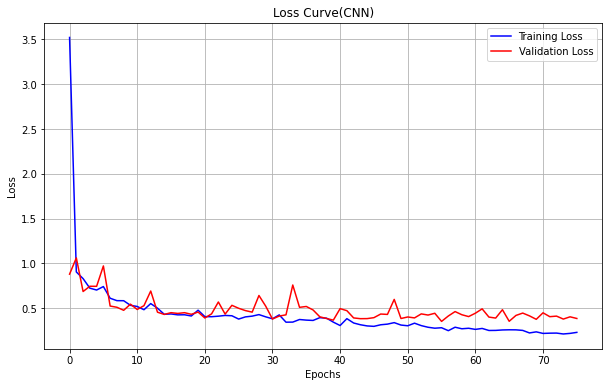

In [11]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss Curve(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training and validation loss curves.png'))
plt.show()



# Predict for the test set data and compare the true value with the predicted value

## Model Prediction:
- The trained model is loaded from the saved file and used to predict the test set (`X_test`).
- The prediction (`y_pred`) is compared with the actual test labels (`y_test`).

## Evaluation Metrics:
- **R² Score (r2)**: Measures the proportion of variance in the true values that is predictable from the model.
- **Mean Absolute Error (MAE)**: Represents the average magnitude of the errors between the predicted and true values.
- **Mean Squared Error (MSE)**: Indicates the average squared difference between the predicted and true values.

## Model Evaluation:
- The following metrics are computed and printed:
  - `r2`: R² score
  - `mse`: Mean Squared Error
  - `mae`: Mean Absolute Error

## Logging:
- The results of the evaluation (R², MSE, and MAE) are logged in the `training_log.txt` file for further analysis.


In [7]:
# Predict test set
model = tf.keras.models.load_model(os.path.join(dir_output, 'best_model.h5'))
y_pred = model.predict(X_test)
# Evaluate on the test set
#test_loss, test_mae = model.evaluate(X_test, y_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
#print R2、MSE、MAE
print(f'Test R2 Score: {r2}')
print(f'Test Loss: {mse}')
print(f'Test MAE: {mae}')
logging.info(f"Test MSE: {mse:.6f}")
logging.info(f"Test R² Score: {r2:.6f}")
logging.info(f"Test MAE Score: {mae:.6f}")

16/16 [==============================] - 0s 7ms/step


Test MSE: 0.443427
Test R² Score: 0.944803
Test MAE Score: 0.467287


Test R2 Score: 0.9448031140012753
Test Loss: 0.4434267052347856
Test MAE: 0.46728693986843206


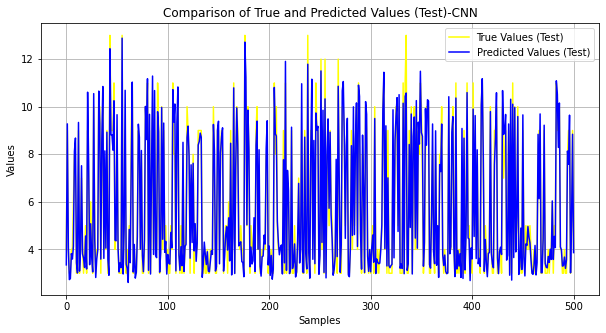

In [12]:
# Draw a comparison chart of the predicted results and the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test,label='True Values (Test)', color='yellow', linewidth=1.5)
plt.plot(y_pred, label='Predicted Values (Test)', color='blue', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of True and Predicted Values (Test)-CNN')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'true_vs_predicted_classification.png'))
plt.show()

